<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Задание</b></h2>

Добейтесь как можно лучшего качества в соревновании!  

[Классификация дорожных знаков](https://www.kaggle.com/c/sweden-traffic-signs-classification)

Общие настройки

In [13]:
# Установим размер классифицируемых изображений 
# Изменяем размер с 50 на 100, дает лучшее схождение для ResNet (10 эпох, вместо 15)
PIC_SIZE = 50 * 2

# Путь к предобработанным данным
data_path = r'./sweden-traffic/'

In [14]:
import datetime
import itertools
import pandas as pd
import numpy as np
import os
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import lr_scheduler

from torchvision import transforms, models

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

from tqdm import tqdm_notebook

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(device))
else:
    print('Using CPU')
    
# torch.save - не любит сохранять модели из ноутбуков
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

print('Версия torch', torch.__version__)

GeForce GTX 1070
Версия torch 1.0.1


Ноутбук создан под версией torch '1.0.1'

In [3]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

### Создадим класс-обёртку для нашего датасета

Датасет, отличается следующим:
1. Загружает файлы в память, что бы снизить время обращений к ним. Хранятся PIL объект (внимание может не хватить памяти)
2. Создает аугментируованные копии изображения, если их количество в датасете меньше медианы + 25%. Медиана считается по списку значений изображений в группе
3. Количество аугментаций не должно сильно превышать среднее значение среди всех групп + 50%
4. Аугментирует все доступные изображения при обращении, за счет этого повышаем точность, дополнительно можно для валидации использовать теже изображения что и в выборке для обучения, т.к. пофакту это разные изображения.

In [18]:
class SignsDataset(Dataset):
    """Road signs dataset."""

    def __init__(self, csv_file, root_dir, normalize=True):
        """
        Args:
            csv_file  (string): Полный путь к csv файлу с датасетом
            root_dir  (string): Директория с файлами
            normalize (boolean): Добавление аугментаций для категорий с малым количеством файлов
        """
        # Читаем файл с данными
        self.signs_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        print(f'{len(self.signs_frame)} samples loaded')
        
        # Преобразования изображения
        self.signs_frame['transf'] = None

        # В тестовом датасете нет ответов
        if "label" in self.signs_frame.columns:
            # Создаем 4 вида аугментаций, потом добавляем их в список
            trans_block4 = transforms.Compose([
                transforms.RandomResizedCrop((PIC_SIZE, PIC_SIZE),
                                             scale=(0.5, 1.0), 
                                             ratio=(0.5, 1.0)),
            ])
            trans_block3 = transforms.Compose([
                transforms.ColorJitter(brightness =[0.7,1.5]),
                transforms.RandomResizedCrop((PIC_SIZE, PIC_SIZE),
                                             scale=(0.5, 1.0), 
                                             ratio=(0.5, 1)),
            ])
            trans_block2 = transforms.Compose([
                transforms.RandomResizedCrop((PIC_SIZE, PIC_SIZE),
                                             scale=(0.5, 1), 
                                             ratio=(0.5, 1)),
                transforms.RandomAffine(degrees=0,
                                        scale = (0.4, 0.9)),
            ])
            trans_block1 = transforms.Compose([
                transforms.RandomAffine(degrees=0,
                                        scale = (0.4, 0.9)),
            ])
            # Список модификаций для изображений
            self.augmentation = [trans_block1,
                                 trans_block2,
                                 trans_block3,
                                 trans_block4,
                                 trans_block1,
                                 trans_block2,
                                 trans_block3,
                                 trans_block4,
                                 trans_block1,
                                 trans_block2,
                                 trans_block3,
                                 trans_block4,
                                ]
            
            # Посчитаем сбалансированность датасета, конвертируем названия в числовые коды
            vals = np.unique(self.signs_frame.label, 
                             return_inverse = True,
                             return_counts = True)

            # Список названий категорий
            self.labels_ = vals[0]
            # Числовые коды (номера каналов)
            self.signs_frame['code'] = vals[1]
            
            # Медиана по количеству картинок
            median = np.median(vals[2]) + 5
            # Среднее значение
            mean = vals[2].mean() * 1.5
            
            if normalize and mean > median:
                self.signs_frame['transf'] = transforms.RandomChoice(self.augmentation)

                for i, (name, count)  in enumerate(zip(vals[0], vals[2])):
                    # Не аугментируем данные количество которых превышает медиану + 25%
                    if count > median * 1.25:
                        continue

                    # Считаем сколько нужно добавить данных, огрвничиваем макс. количество 
                    # аугментированных значений
                    diff = mean - count

                    # Копируем все строки, одной категории
                    transf_df = self.signs_frame[self.signs_frame.label == name].copy()
                    
                    for transf in self.augmentation:
                        # Добавляем аугментации
                        transf_df.transf = transf
                        self.signs_frame = self.signs_frame.append(transf_df.copy(), 
                                                                   ignore_index=True)
                        diff -= len(transf_df.transf)
                        # Стараемся не сильно превышать среднее количество примеров
                        if diff <= 0:
                            break
                    
        else:
            self.signs_frame['label'] = self.signs_frame['file_name']
            self.signs_frame['code'] = self.signs_frame.index

        # Обязательные преобразование
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        
        self.images_ds = list()
        for i in range(len(self.signs_frame)):
            # Получаем полный путь к файлу
            img_name = self.root_dir + self.signs_frame.file_name[i]
            image = Image.open(img_name)
            image.load()

            image = image.resize((PIC_SIZE, PIC_SIZE), Image.ANTIALIAS)
        
            if self.signs_frame.transf[i] is None:
                # Дополнительные трансформации
                image = np.array(image, dtype='float32') / 255
                image = self.transform(image)
            self.images_ds.append(image)

    @property
    def labels(self):
        # Текстовые метки датасета
        return self.labels_.copy()
    
    def __len__(self):
        return len(self.signs_frame)

    def random_split(self, percent):
        # Разбивка датасета на тренировочный и валидационный
        # percent - доля валидационного датасета

        percent = min(max(0, percent), 1)
        val_len = round(len(self) * percent)

        return random_split(self, [len(self) - val_len, val_len])

    def __getitem__(self, idx):
        idx = int(idx)
        
        # Загрузим изображение
        image = self.images_ds[idx]

        # Случайные преобразования изображения
        if self.signs_frame.transf[idx] is not None:
            image = self.signs_frame.transf[idx](image)

            # Дополнительные трансформации
            image = np.array(image, dtype='float32') / 255
            image = self.transform(image)

        return image, self.signs_frame.code[idx]

### Создадим DataLoader'ы, облегчающие закрузку и сэмплинг данных

Есть два способа обучения:
1. Используем два датасета. Один из текущего задания, другой из лекции 9. Однозначного запрета на этот вариант, не было. Для проверки, нужно выкачать архив `"data2.zip"`, список файлов `train2.csv`. Датасет набрал: публичный **0.99672**, закрытый ResNet34 **1.00000**, vgg16bn **0.99672** 
  
2. Используем только текущий датасет и дополняем весами, полученными на датасете с немецкими знаками `german_vgg16bn.pth` 513Мб. Данный вариант просчитан только для `VGG-16 with batch normalization`. Т.к. именно это была основная архитектура, до появления варианта 1. Датасет набрал: публичный **0.98360**, закрытый **0.99016**

In [5]:
# Вариант 1
full_dataset = SignsDataset(data_path + 'train2.csv', 
                            data_path + 'data2\\',
                            True)
double_ds = True
classes_number = len(full_dataset.labels)

5616 samples loaded


In [20]:
# Вариант 2
full_dataset = SignsDataset(data_path + 'train.csv', 
                            data_path + 'data\\',
                            True)
double_ds = False
classes_number = len(full_dataset.labels)

2503 samples loaded


In [6]:
# Разбиение датасета на train и validation
train_ds, validation_ds = full_dataset.random_split(0.20)
    
signsTrainLoader = DataLoader(full_dataset, batch_size=16, shuffle=True)
signsValidationLoader = DataLoader(validation_ds, batch_size=128, shuffle=False)


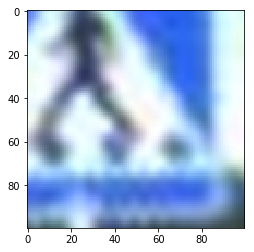

In [7]:
# Изображения в dataset
imshow(full_dataset[0][0])

### Данные сильно несбалансированы (unbalanced dataset)

In [ ]:
print("classes_number", classes_number)
df = full_dataset.signs_frame
df.groupby('label').label.count()

## Выбираем и обучаем сеть

Остановил свой выбор на двух архитектурах `ResNet-34` и `VGG-16 with batch normalization`. От `Inception v3` отказался, т.к. итоговая точность такая же, но процесс ее обучения занимает намного больше времени.  
`Inception v3` оказался вообще загадочной штукой, открытый скор *0.96721*, закрытый *0.98360*. Для него совпало так, что он плохо распознавал данные из открытой части.
  
Не нужное закоментировать, нужное - расскоментировать

In [8]:
# nn_type = "resnet34"
nn_type = "vgg16_bn"

# Шаг алгоритма оптимизации
learning_rate = 1e-4

# Изменение скорости обучение (learning rate scheduling). 
# Используем для лучшей сходимости, подобрал анализируя график точности валидации, после 
# определенного шага его начинает бросать из +/-, в этот момент нужно уменьшить lr
step_size=6


Процедуры генерации сети:
    1. ResNet-34

In [5]:
def get_resnet(classes, device):
    tmp_model = models.resnet34(pretrained=False)
    tmp_model.fc = nn.Linear(512, classes)
    return tmp_model.to(device)
    

    2. VGG-16 with batch normalization

In [6]:
def get_vgg(classes, device, pretrained=False):
    tmp_model = models.vgg16_bn(pretrained=False)
    
    if pretrained:
        # Загрузим веса, от тренировки на датасете знаков германии
        tmp_model.classifier = nn.Sequential(nn.Linear(25088, 4096),
                                             nn.ReLU(),
                                             nn.Dropout(p=0.5),
                                             nn.Linear(4096, 4096),
                                             nn.ReLU(),
                                             nn.Dropout(p=0.5),
                                             nn.Linear(4096, 43),
                                            )
        tmp_model = tmp_model.to(device)
        tmp_model.load_state_dict(torch.load(data_path + "german_vgg16bn.pth"))
    tmp_model.classifier = nn.Sequential(nn.Linear(25088, 4096),
                                         nn.ReLU(),
                                         nn.Dropout(p=0.5),
                                         nn.Linear(4096, 4096),
                                         nn.ReLU(),
                                         nn.Dropout(p=0.5),
                                         nn.Linear(4096, classes),
                                        )
    return tmp_model.to(device)
    

Создание модели заданной архитектуры

In [11]:
# Временная отметка (для логирования файлов, что бы понимать в какое время были получены данные)
time_stamp = datetime.datetime.today().strftime("%Y%m%d_%H%M%S")

if nn_type == "resnet34" and double_ds:
    model = get_resnet(classes_number, device)
elif nn_type == "vgg16_bn" or not double_ds:
    nn_type = "vgg16_bn"
    model = get_vgg(classes_number, device, True)


Функция возвращает по модели: точность, предсказания, loss

In [12]:
def model_check(chk_model, check_ds, device, accurency=False, predict=False, loss_fn=None):
    # Переводим модель в режим "предсказания"
    chk_model.eval()
    # Для Inception нужны дополнительные операции
    inc_v3 = isinstance(chk_model, models.inception.Inception3)
    # Можем возвращать несколько разных значений
    result = []
    
    # Отключаем градиенты
    with torch.no_grad(): 
        acc = np.array([])
        loss = np.array([])
        # Отключаем хвосты для Inception v3
        if inc_v3:
            chk_model.aux_logits = False

        for x, y in check_ds:
            x, y = x.to(device), y.to(device)
            y_pred = chk_model(x)
            
            if loss_fn is not None:
                loss = np.append(loss, loss_fn(y_pred, y).item())
                
            y_pred = torch.argmax(y_pred, 1)
            acc = np.append(acc, (y == y_pred).cpu().numpy())

    # Точность
    if accurency:
        result.append(acc.mean().item() if len(acc) != 0 else 0)
    # Loss
    if loss_fn is not None:
        result.append(loss.mean().item() if len(loss) != 0 else 0)

    # Восстанавливаем режим обучения
    chk_model.train()
    # Включаем хвосты для Inception v3
    if inc_v3:
        chk_model.aux_logits = False
    
    return result[0] if len(result) == 1 else tuple(result)


In [13]:
# Лог с результатами работы
history = {'loss':[], 'val_loss':[]}

# Функция потерь, стандартно без изменений
loss_fn = torch.nn.CrossEntropyLoss().to(device)

# Алгоритм оптимизации
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Умножает learning_rate на 0.1 каждые step_size эпох
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

try:
    # Inception возвращает кортеж значений + aux хвосты
    inc_v3 = isinstance(model, models.inception.Inception3)
    # Переводим модель в режим обучения
    model.train()
    if inc_v3:
        model.aux_logits = True

    # Инициализируем начальные значения
    val_acc = np.array([])
    batch_loss = np.array([])
    i = 0

    # Создаем объект прогресс бара, что бы в дальнейшем выводить на нем информацию
    pbar = tqdm_notebook(range(10), desc="epoch")
    for epoch in pbar:

        # Считаем шаги, до уменьшения lr
        exp_scheduler.step()

        pbatch = tqdm_notebook(signsTrainLoader, desc="batch", leave=False)
        for X_batch, y_batch in pbatch:
            # Текущий батч
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Обнуляем веса
            optimizer.zero_grad()

            # forwrd
            pred = model(X_batch)
            if inc_v3:
                # предсказания + aux хвост 
                y_pred, ax_pred = model(X_batch)
                # loss считается отдельно, для каждой части
                loss1 = loss_fn(y_pred, y_batch)
                loss2 = loss_fn(ax_pred, y_batch)
                # общий loss считаем так (нашел в интернете, как базовый вариант)
                loss = loss1 + 0.4 * loss2
            else:
                loss = loss_fn(pred, y_batch)

            # backward + optimize
            loss.backward()
            optimizer.step()

            # Выведем текущий loss в прогресс бар
            batch_loss = np.append(batch_loss, loss.item())
            pbatch.set_description(f"batch [loss: {batch_loss.mean():.3f}]")

            # Пишем в лог каждые 50 батчей
            # Оставлю как в базовом решении, не знаю почему именно 50 - но пусть будет)
            if i % 50 == 49:
                history['loss'].append(loss.item())
                # Loss валидационной выборки
                tmp_loss = model_check(model, signsValidationLoader, device, 
                                       loss_fn=loss_fn)
                history['val_loss'].append(tmp_loss)
            i += 1

        # Считаем точность после каждой эпохи
        tmp_acc = model_check(model, signsValidationLoader, device, 
                              accurency=True)
        val_acc = np.append(val_acc, tmp_acc)
            
        if tmp_acc > 0.98:
            save_name = f"{nn_type}_{time_stamp}_{val_acc[-1]:.4f}_{epoch}.pth"
            torch.save(model.state_dict(), save_name)
            print("Сохраняем:", save_name)

        # Выводим точность модели и дельту с предудыщим значением
        delta = 0 if len(val_acc) < 2 else (val_acc[-1] - val_acc[-2])
        pbar.set_description(f"epoch [acc: {val_acc[-1]:.3f}/{delta:.3f}]")
        

except KeyboardInterrupt:
    # Перехватываем "interrupt kernel"
    print('Повинуюсь')
    
print('Обучение закончено')
if len(val_acc) > 0:
    print(f"{val_acc.max():.4f}")

Сохраняем: vgg16_bn_20190515_232819_0.9875_6.pth


Сохраняем: vgg16_bn_20190515_232819_0.9890_7.pth


Сохраняем: vgg16_bn_20190515_232819_0.9910_8.pth


Сохраняем: vgg16_bn_20190515_232819_0.9910_9.pth

Обучение закончено
0.9910


После обучения получаем набор сохраненных моделей, тестим на колабе и выбираем лучшую, отбираем по убыванию номера эпохи. Т.к. сделано уменьшения *learning rate* и подобрано "нужное" количество эпох (до того как начнется момент переобучения, выбрано после ряда прогонов и внимательного вглядывания в графики), сильно переобучить модель мы не должны.  

### Начертим кривые обучения

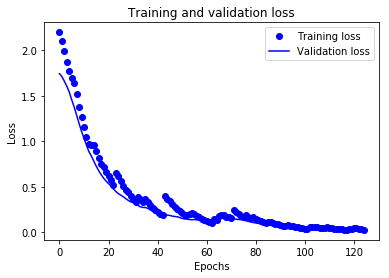

In [14]:
# Скользящее среднее (оставляем без изменения)
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.clf()
loss_values = smooth_curve(history['loss'])
val_loss_values = smooth_curve(history['val_loss'])
epochs = np.arange(len(loss_values))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Выведем confusion matrix

In [15]:
# Оставляем без изменения
    
# Воспользуемся функцией из документации matplotlib, выводящей confusion matrix 
# Source https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()

Normalized confusion matrix


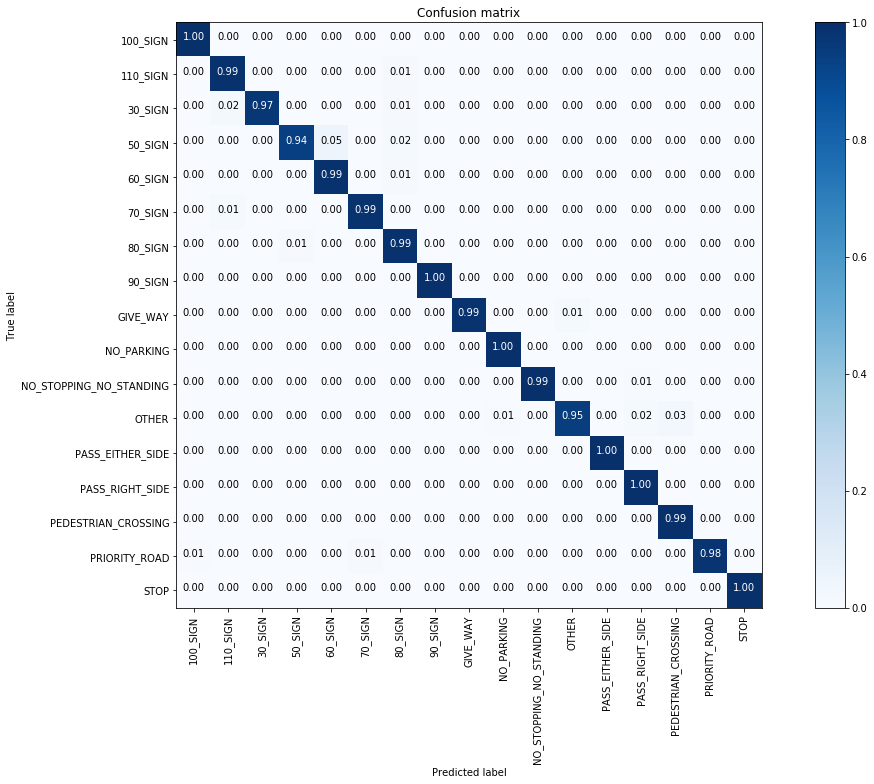

In [16]:
if isinstance(model, models.inception.Inception3):
    model.aux_logits = False

y_test_all = torch.Tensor().long()
predictions_all = torch.Tensor().long()

# Пройдём по всему validation датасету и запишем ответы сети
with torch.no_grad():
    for x_batch, y_batch in signsValidationLoader:
        x_batch = x_batch.to(device)
        predictions = model(x_batch)
        _, predictions = torch.max(predictions.cpu(), 1)
        
        # Аналог append для list
        y_test_all = torch.cat((y_test_all, y_batch), 0)
        predictions_all = torch.cat((predictions_all, predictions), 0)

feature_names = full_dataset.labels

y_test_all = y_test_all.numpy()
predictions_all = predictions_all.numpy()

# Функция из sklearn, создаёт confusion матрицу
cm = confusion_matrix(y_test_all, predictions_all, np.arange(classes_number))
# Выведем её
plot_confusion_matrix(cm, full_dataset.labels, normalize=True)

### Выведем точность для каждого класса

In [17]:
class_correct = [0 for i in range(classes_number)]
class_total = [0 for i in range(classes_number)]

c = (predictions_all == y_test_all).squeeze()
for i in range(len(predictions_all)):
    label = predictions_all[i]            
    class_correct[label] += c[i].item()
    class_total[label] += 1

print(class_total)

for i in range(classes_number):
    print('Accuracy of %5s : %2d %%' % (
        (full_dataset.labels[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

[91, 101, 103, 64, 92, 72, 108, 92, 68, 107, 136, 132, 99, 167, 272, 181, 123]
Accuracy of 100_SIGN : 100 %
Accuracy of 110_SIGN : 99 %
Accuracy of 30_SIGN : 97 %
Accuracy of 50_SIGN : 93 %
Accuracy of 60_SIGN : 98 %
Accuracy of 70_SIGN : 98 %
Accuracy of 80_SIGN : 99 %
Accuracy of 90_SIGN : 100 %
Accuracy of GIVE_WAY : 98 %
Accuracy of NO_PARKING : 100 %
Accuracy of NO_STOPPING_NO_STANDING : 99 %
Accuracy of OTHER : 94 %
Accuracy of PASS_EITHER_SIDE : 100 %
Accuracy of PASS_RIGHT_SIDE : 100 %
Accuracy of PEDESTRIAN_CROSSING : 99 %
Accuracy of PRIORITY_ROAD : 98 %
Accuracy of  STOP : 100 %


# Генерация файла ответов на test
Создаем тестовый датасет

In [18]:
test_dataset = SignsDataset(data_path + 'test.csv', 
                            data_path + 'data//',
                            False)

# DataLoader достаёт данные из dataset батчами
signsTestLoader = DataLoader(test_dataset, batch_size=1)

610 samples loaded


Загружаем веса, полученные в ходе соревнования (в зависимости от выбранной модели)

In [21]:
if nn_type == "resnet34":
    model = get_resnet(classes_number, device)
    model.load_state_dict(torch.load("sweden_resnet_0.99.pth"))
elif nn_type == "vgg16_bn":
    model = get_vgg(classes_number, device, False)
    if double_ds:
        model.load_state_dict(torch.load("sweden_vgg16bn_0.99.pth"))
    else:
        model.load_state_dict(torch.load("sweden_vgg16bn_0.98.pth"))

model.eval()
pass

Создаем файл с предсказаниями

In [21]:
answer = []

with torch.no_grad(): 
    model.eval()
    for x_batch, y_batch in signsTestLoader:
        x_batch = x_batch.to(device)
        predictions = model(x_batch)
        _, predictions = torch.max(predictions.cpu(), 1)
        answer.append(full_dataset.labels[predictions[0]])

prediction_df = pd.DataFrame({"file_name": test_dataset.signs_frame.file_name.copy(),
                              "label": answer})
    
# "Уникальное" имя файла
today = datetime.datetime.today().strftime("%Y%m%d_%H%M%S")
today = f"road_sign_{today}.csv"

prediction_df.to_csv(today, index=False)
print("Файл сохранен:", today)

Файл сохранен: road_sign_20190515_235624.csv
